In [1]:
# Marketing AB Testing by David Fx -  dataset from Kaggle

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from scipy.stats import chi2_contingency as chi2c
import random
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
df=pd.read_csv('D:\DATA ANALYST\AB TESTING\marketing_AB.csv',low_memory=False)
df

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14
...,...,...,...,...,...,...,...
588096,588096,1278437,ad,False,1,Tuesday,23
588097,588097,1327975,ad,False,1,Tuesday,23
588098,588098,1038442,ad,False,3,Tuesday,23
588099,588099,1496395,ad,False,1,Tuesday,23


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB


In [5]:
df.describe(include="all")

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
count,588101.000000,5.881010e+05,588101,588101,588101.000000,588101,588101.000000
unique,NaN,NaN,2,2,NaN,7,NaN
top,NaN,NaN,ad,False,NaN,Friday,NaN
freq,NaN,NaN,564577,573258,NaN,92608,NaN
mean,294050.000000,1.310692e+06,NaN,NaN,24.820876,NaN,14.469061
std,169770.279667,2.022260e+05,NaN,NaN,43.715181,NaN,4.834634
min,0.000000,9.000000e+05,NaN,NaN,1.000000,NaN,0.000000
25%,147025.000000,1.143190e+06,NaN,NaN,4.000000,NaN,11.000000
50%,294050.000000,1.313725e+06,NaN,NaN,13.000000,NaN,14.000000
75%,441075.000000,1.484088e+06,NaN,NaN,27.000000,NaN,18.000000


In [6]:
df.columns

Index(['Unnamed: 0', 'user id', 'test group', 'converted', 'total ads',
       'most ads day', 'most ads hour'],
      dtype='object')

In [7]:
# Insight from the columns :
# Objectives 1 : Check conversion rate for each test group
# Objectives 2 : Check correlation between the number of ads shown and conversion rates
# Objectives 3 : Examine ‘most ads day’ and ‘most ads hour’ to find out if there are specific times when users are more likely to convert

In [8]:
# check for duplicate

In [9]:
dupli = df.duplicated()
print(dupli.any())

False


In [10]:
# make column names uniform and replace space with _

In [11]:
df.rename(columns=lambda x: x.strip().replace(" ", "_"), inplace=True)
df.columns

Index(['Unnamed:_0', 'user_id', 'test_group', 'converted', 'total_ads',
       'most_ads_day', 'most_ads_hour'],
      dtype='object')

In [12]:
# Remove column 'Unnamed:_0'

In [13]:
df = df.drop(["Unnamed:_0"], axis =1)
df.columns

Index(['user_id', 'test_group', 'converted', 'total_ads', 'most_ads_day',
       'most_ads_hour'],
      dtype='object')

In [14]:
# check for missing values

In [15]:
missing=df.isnull().values.sum()
print(missing)
df.isnull().any()

0


user_id          False
test_group       False
converted        False
total_ads        False
most_ads_day     False
most_ads_hour    False
dtype: bool

In [16]:
# add boolean 'converted' into integer 'converted value'

In [17]:
df["converted_val"] = df['converted'].apply(lambda x:1 if x== True  else  0)
df.head()

,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour,converted_val
0,1069124,ad,False,130,Monday,20,0
1,1119715,ad,False,93,Tuesday,22,0
2,1144181,ad,False,21,Tuesday,18,0
3,1435133,ad,False,355,Tuesday,10,0
4,1015700,ad,False,276,Friday,14,0


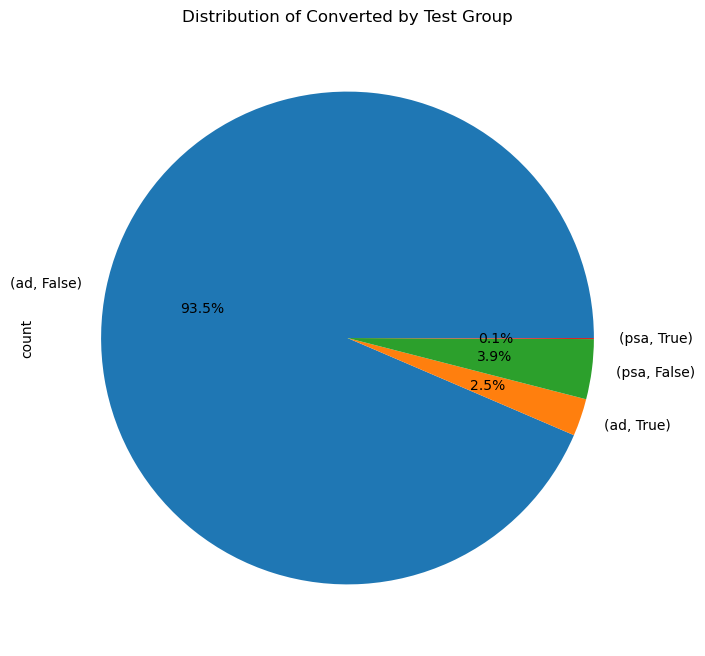

In [18]:
tgcount = df.groupby('test_group')['converted'].value_counts()
#df['test_group'].value_counts()
tgcount.plot.pie(figsize= (8,8),autopct='%1.1f%%')
#plt.figure(figsize=(8, 8))
#plt.pie(tgcount, labels=tgcount.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Converted by Test Group')
plt.show()

In [19]:
# OBJECTIVE 1 : Check conversion rate for each test group

In [20]:
conversion_summary = df.groupby('test_group').agg({'converted_val': 'sum', 'total_ads': 'sum'})
conversion_summary['conversion_rate'] = conversion_summary['converted_val'] / conversion_summary['total_ads']
print(conversion_summary['conversion_rate'])
contingency_table = pd.crosstab(df['test_group'], df['converted_val'])

# Perform the chi-squared test
chi2, p, dof, expected = chi2c(contingency_table)

print(f"Chi-squared: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print(f"Expected frequencies:\n{expected}")

# Determine if the result is statistically significant
if p < 0.05:
    print("The difference in conversion rates is statistically significant.")
else:
    print("The difference in conversion rates is not statistically significant.")

test_group
ad     0.001029
psa    0.000721
Name: conversion_rate, dtype: float64
Chi-squared: 54.005823883685245
P-value: 1.9989623063390075e-13
Degrees of freedom: 1
Expected frequencies:
[[550327.71899045  14249.28100955]
 [ 22930.28100955    593.71899045]]
The difference in conversion rates is statistically significant.


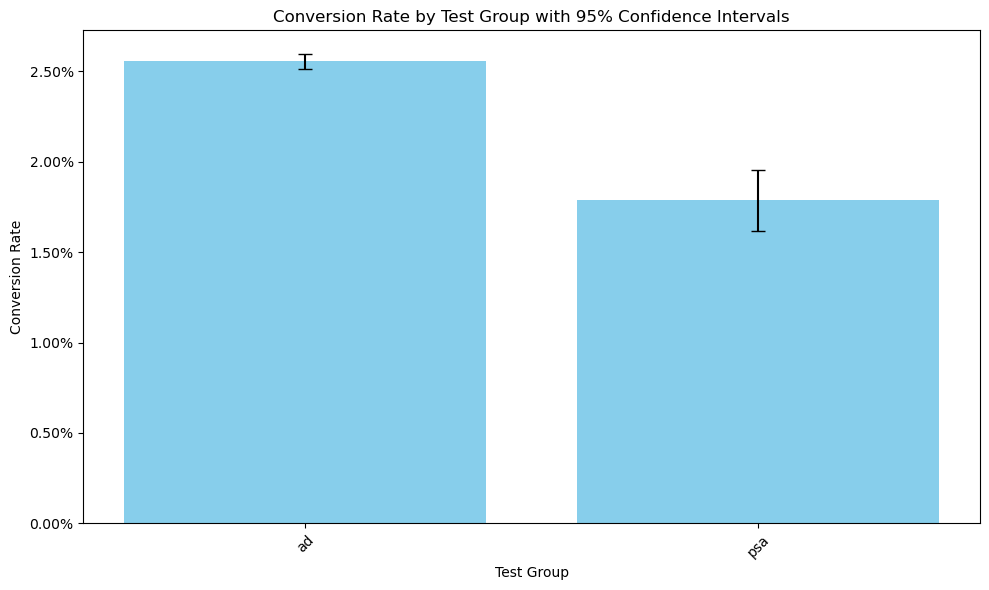

In [21]:
# Calculate conversion rates
conversion_rates = df.groupby('test_group')['converted_val'].mean()

# Calculate the standard error for each test group
standard_errors = df.groupby('test_group')['converted_val'].apply(lambda x: stats.sem(x.astype(float)))

# Calculate the confidence intervals
confidence_intervals = standard_errors * stats.t.ppf((1 + 0.95) / 2., df.groupby('test_group').size() - 1)

# Create bar chart
plt.figure(figsize=(10, 6))
bar_chart = plt.bar(conversion_rates.index, conversion_rates, yerr=confidence_intervals, color='skyblue', capsize=5)

from matplotlib.ticker import PercentFormatter
plt.xlabel('Test Group')
plt.ylabel('Conversion Rate')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Conversion Rate by Test Group with 95% Confidence Intervals')
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

In [22]:
# OBJECTIVE 2 : Check correlation between the number of ads shown and conversion rates

In [23]:
# 1. Analyze the 'total_ads' column to see if there's a correlation between the number of ads shown and conversion rates.
correlation, p_value = stats.pearsonr(df['total_ads'], df['converted_val'])
print(f"Correlation coefficient: {correlation}")
print(f"P-value: {p_value}")

# 2. Perform a regression analysis to understand the impact of ad frequency on conversion
X = df['total_ads']  # Predictor
Y = df['converted_val']  # Response
X = sm.add_constant(X)  # Adds a constant term to the predictor
model = sm.OLS(Y, X).fit()
print(model.summary())

Correlation coefficient: 0.21741921577340095
P-value: 0.0
                            OLS Regression Results                            
Dep. Variable:          converted_val   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                 2.918e+04
Date:                Thu, 06 Jun 2024   Prob (F-statistic):               0.00
Time:                        15:30:20   Log-Likelihood:             2.6920e+05
No. Observations:              588101   AIC:                        -5.384e+05
Df Residuals:                  588099   BIC:                        -5.384e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

In [24]:
# Correlation coeff 0.2174 suggests a positive but weak relationship between number of ads shown (total_ads) and the conversion rates (converted_val).
# The p-value of 0.0 indicates that this correlation is statistically significant.
# This means that there is a very low probability that this correlation is due to random chance

In [25]:
# OBJECTIVE 3 : Examine ‘most ads day’ and ‘most ads hour’ to find out if there are specific times when users are more likely to convert

In [26]:
# Group data by 'day' and 'hour' and calculate the mean conversion rate
daily_conversion = df.groupby('most_ads_day')['converted_val'].mean()
hourly_conversion = df.groupby('most_ads_hour')['converted_val'].mean()

# Find the day and hour with the highest average conversion rate
most_ads_day = daily_conversion.idxmax()
most_ads_hour = hourly_conversion.idxmax()

print(f"Day with most conversions: {most_ads_day}")
print(f"Hour with most conversions: {most_ads_hour}")

Day with most conversions: Monday
Hour with most conversions: 16


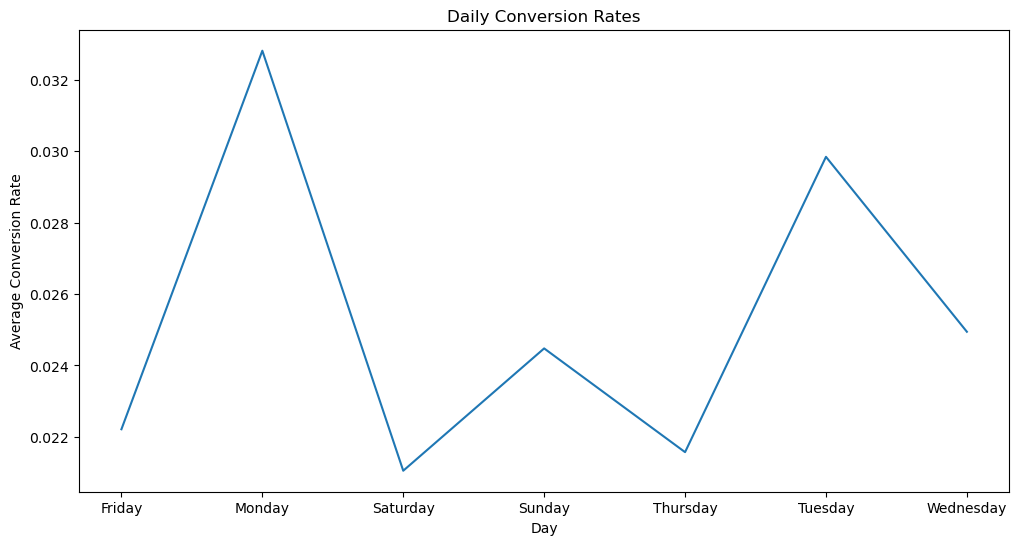

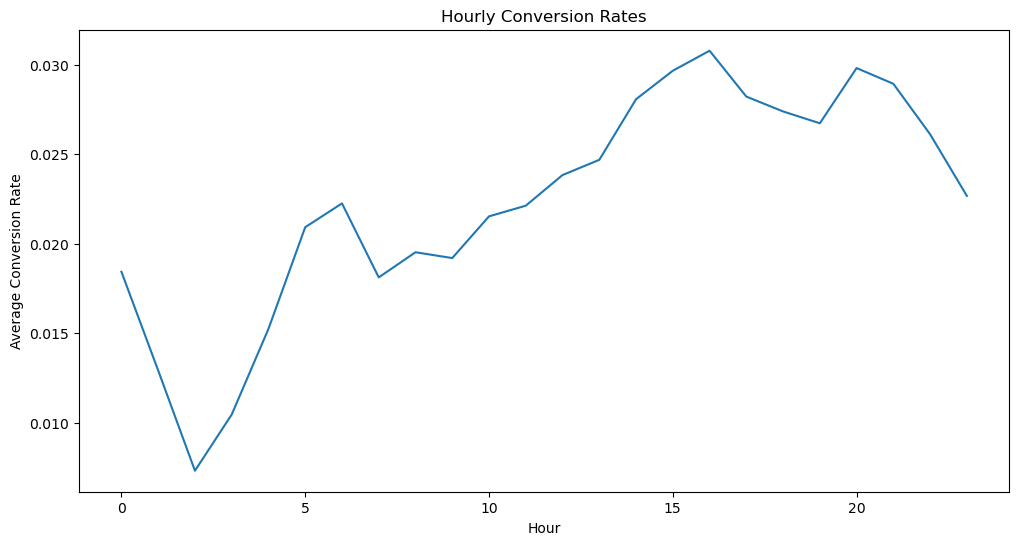

In [27]:
# Time-series plot for daily conversions
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_conversion)
plt.title('Daily Conversion Rates')
plt.xlabel('Day')
plt.ylabel('Average Conversion Rate')
plt.show()

# Time-series plot for hourly conversions
plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_conversion)
plt.title('Hourly Conversion Rates')
plt.xlabel('Hour')
plt.ylabel('Average Conversion Rate')
plt.show()

In [28]:
from statsmodels.formula.api import ols
model = ols('converted_val ~ C(most_ads_day)', data=df).fit()

# Perform ANOVA
anova_results = sm.stats.anova_lm(model, typ=2)
print(anova_results)

                       sum_sq        df          F        PR(>F)
C(most_ads_day)     10.087941       6.0  68.388184  1.803201e-85
Residual         14458.291629  588094.0        NaN           NaN


In [29]:
# from ANOVA, we find The value of F 68.388184 suggests that the means among the days are significantly different.

In [30]:
# AND, A p-value of 1.803201e-85 is extremely small, indicating that the observed difference in means is highly statistically significant.

In [31]:
# So, we have these highly statistically significant results :
# Day with most conversions: Monday
# Hour with most conversions: 16